In [12]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
from brainpy._src.integrators import JointEq
from brainpy._src.context import share
bp.math.set_dt(0.05)

In [13]:
class A2(bp.neurons.HH):
    def __init__(self, size, ENa=120., EK=-12., EL=10.6, C=1.0, gNa=120.,
               gK=36, gL=0.3, V_th=0., method='exp_auto'):
        super().__init__(size=size, method=method)
        self.size = size

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        self.input = bm.Variable(bm.ones(size) * 9)
        self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

    def dm(self, m, t, V):
        alpha =  0.1*(25-V) / (bm.exp(2.5 - 0.1*V)-1) #0.1 * (25-V) / (bm.exp(-0.1 * (V - 25)) - 1)
        beta = 4.0*bm.exp(-V/18.0) # 4 * bm.exp(-V / 18)
        dmdt = alpha * (1 - m) - beta * m
        return dmdt

    def dn(self, n, t, V):
        alpha = 0.01*(10.0-V)/ (bm.exp(1.0-0.1*V )-1) #0.01 * (10-V) / (bm.exp(0.1 * (10-V)) - 1)
        beta = 0.125*bm.exp(-V/80.0) #0.125 * bm.exp(-V / 80)
        dndt = alpha * (1 - n) - beta * n
        return  dndt

    def dh(self, h, t, V):
        alpha = 0.07*bm.exp(-V/20.0) #0.07 * bm.exp(-V / 20)
        beta = 1/(1+bm.exp(3.0-0.1*V)) #1 / (bm.exp(0.1 * (-V + 30)) + 1)
        dhdt = alpha * (1 - h) - beta * h
        return dhdt

    def dV(self, V, t, m, h, n, I):
        INa = self.gNa * m ** 3 * h * (V - self.ENa)
        IK = self.gK * n ** 4 * (V - self.EK)
        IL = self.gL * (V - self.EL)
        dVdt = (- INa - IK - IL + I) / self.C
        return dVdt

    @property
    def derivative(self):
        return JointEq(self.dV, self.dm, self.dh, self.dn)  # , self.dh, self.dn, self.ds, self.dc, self.dq)


In [34]:
class BaseAMPASyn(bp.dyn.SynConn):
    def __init__(self, pre, post, conn, delay=0, g_max=0.001, E=20, alpha=0.98,
               beta=0.18, 
               T=1, T_duration=1, perturbation_amplitude = 2.5,perturbation_interval=14.0, pulse_width=1.0,method='exp_auto'):
        super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

        # check whether the pre group has the needed attribute: "spike"
        self.check_pre_attrs('spike')

        # check whether the post group has the needed attribute: "input" and "V"
        self.check_post_attrs('input', 'V')

        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
        self.delay_step = int(delay/bm.get_dt())
        self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

        # store the arrival time of the pre-synaptic spikes
        self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

        # integral function
        self.integral = bp.odeint(self.derivative, method=method)
        self.perturbation_amplitude = perturbation_amplitude
        self.perturbation_interval = perturbation_interval
        self.pulse_width = pulse_width

    def derivative(self, g, t, TT):
        dg = self.alpha * TT * (1 - g) - self.beta * g
       
        # dg =  (-self.beta * g + self.alpha *TT*((1-g)*5)/(1+bm.exp(-(self.pre.V+3)/8)))  # according to paper 
        #dg =  (-g + TT*((1-g)*5)/(1+bm.exp(-(self.pre.V+3)/8))) #this also works
        
        return dg
    
    def generate_perturbation(self, t):
        phase = t % self.perturbation_interval
        return self.perturbation_amplitude * bm.less(phase, self.pulse_width)
    
   

In [35]:
class AMPAAll2All(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPAAll2All, self).__init__(*args, **kwargs)
    # connection matrix
    self.conn_mat = self.conn.require('conn_mat').astype(float)
    self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))
    
    

  def update(self, x=None):
    _t, _dt = bp.share['t'], bp.share['dt']
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
    
    TT = TT.reshape((-1, 1))* self.conn_mat
    
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    
    g_post = self.g.sum(axis=0)
    perturbation = self.generate_perturbation(_t)
    self.post.input += bm.dot(self.g_max , g_post) *(self.E - self.post.V)  + perturbation

    

  0%|          | 0/18000 [00:00<?, ?it/s]

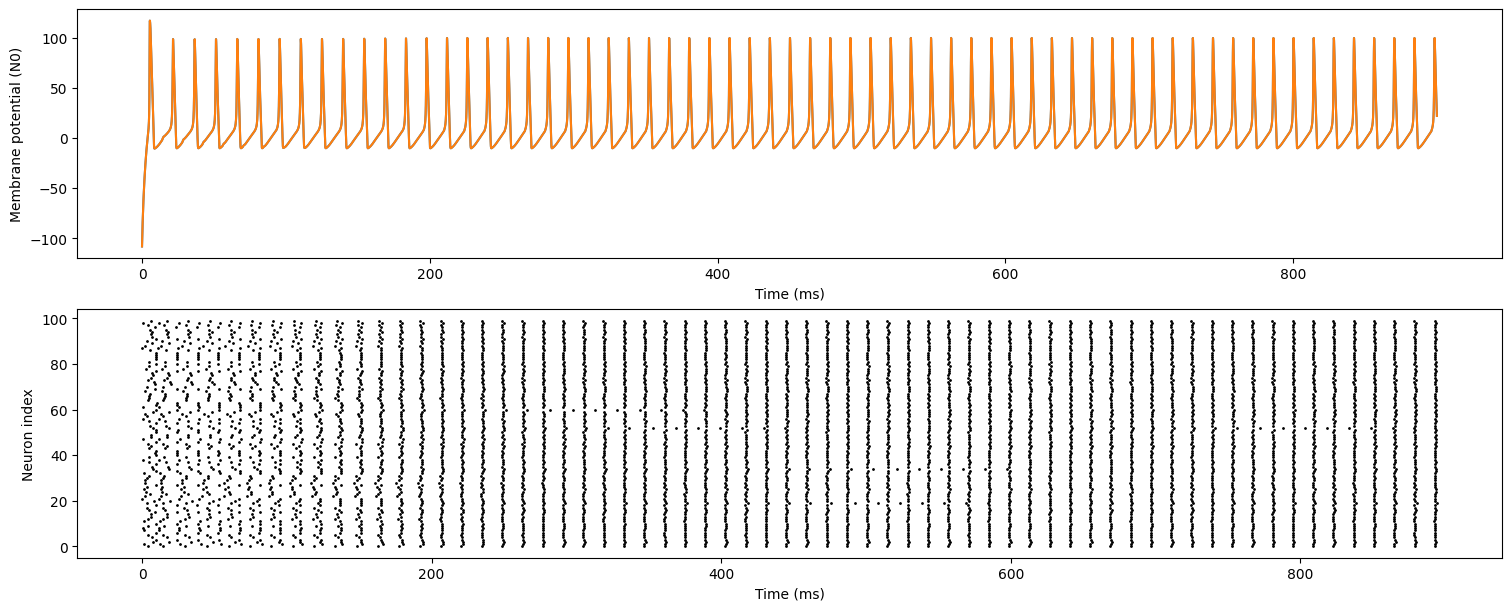

In [36]:
num = 100
neu = A2(num)
neu.V[:] = -70. + bm.random.normal(size=num) * 20*10

# Random network connectivity
conn = bp.connect.FixedProb(prob=0.5, include_self=False) # 10% connection probability, adjust as needed
syn = AMPAAll2All(pre=neu, post=neu, conn=conn)

# Random input currents
input_currents = bm.random.uniform(9.0, 10.0, num)

net = bp.Network(neu=neu, syn=syn)
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input', input_currents])

runner.run(duration=900.) 

fig, gs = bp.visualize.get_figure(2, 1, 3, 15)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=True)
plt.show()



In [6]:
import ipywidgets as widgets
from IPython.display import display

In [31]:
def run_simulation(E,prob,perturbation_amplitude):
    # Reset the network and runner
    neu = A2(num)
    neu.V[:] = -70. + bm.random.normal(size=num) * 20*10
    conn = bp.connect.FixedProb(prob=prob, include_self=False)
    syn = AMPAAll2All(pre=neu, post=neu, conn=conn, E=E,perturbation_amplitude=perturbation_amplitude)
    shape = (100,100)
    syn.g_max = bp.init.Normal(0.01,0.02)(shape)/100
    # print('weights=', syn.g_max)
    net = bp.Network(neu=neu, syn=syn)
    runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input', input_currents])
    
    runner.run(duration=900.)
    
    fig, gs = bp.visualize.get_figure(1, 1, 3, 15)
    
    fig.add_subplot(gs[0, 0])
#     bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
    
#     fig.add_subplot(gs[1, 0])
    bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=False)
    plt.show()

In [32]:
E_slider = widgets.IntSlider(
    value=20,
    min=-100,
    max=100,
    step=5,
    description='E:',
    continuous_update=False
)

prob_slider = widgets.FloatSlider(
    value=0.5, 
    min=0.0, max=1.0, 
    step=0.1, 
    description='Prob:',
    continuous_update=False)

Perturbation_slider = widgets.FloatSlider(
    value=2.5,
    min=0,
    max=10,
    step=0.5,
    description='Perturb:',
    continuous_update=False
)

widgets.interactive(run_simulation, E=E_slider,prob=prob_slider, perturbation_amplitude=Perturbation_slider)

interactive(children=(IntSlider(value=20, continuous_update=False, description='E:', min=-100, step=5), FloatS…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_perturbation(t, perturbation_amplitude=1.0, interval=14.0, pulse_width=1.0):
    # Calculate the phase within each interval
    phase = t % interval
    # Create a pulse that's high for pulse_width ms at the start of each interval
    return perturbation_amplitude * bm.less(phase, pulse_width)

# Create a time array from 0 to 100 ms with 0.1 ms steps
t = np.arange(0, 100, 0.1)

# Calculate the perturbation values
perturbation = generate_perturbation(t, pulse_width=1.0)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(t, perturbation)
plt.title('Perturbation Function Over Time (1ms pulse every 14ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Perturbation Amplitude')
plt.grid(True)

# Add vertical lines every 14 ms to highlight the periodicity
for i in range(0, 101, 14):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()